In [1]:
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from utils.calculate_pmi_features import get_data
from utils.textnormalization import split_on_word, normalize
from utils.happyfuntokenizing import Tokenizer

plt.style.use('ggplot')
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
mpl.rc('savefig', dpi=200)
params = {'figure.dpi' : 200,
          'axes.axisbelow' : True,
          'lines.antialiased' : True}

for (k, v) in params.items():
    plt.rcParams[k] = v

In [3]:
def sentences(s_list):
    words = split_on_word(s_list)
    words_norm = normalize(words)
    return [' '.join(s) for s in words_norm]

In [4]:
df = get_data()

In [5]:
TAG_RE = re.compile(r'<[^>]+>')

essays = ['essay' + str(i) for i in range(10)]
for e in essays:
    df[e] = df[e].replace(np.nan, '' , regex=True)    \
                 .replace('\n', ' ')                  \
                 .apply(lambda x: TAG_RE.sub(' ', x)) \
                 .apply(lambda x: re.sub('\s+', ' ', x).strip())

df.fillna('', inplace=True)
df['ethnicity_'] = df.ethnicity.apply(lambda x: 'multi' if ',' in x else x)
df['token_count'] = df.TotalEssays.str.split().str.len()

In [6]:
df_token_threshold = df[df.token_count >= 100]
df_token_threshold.reset_index(drop=True, inplace=True)

In [7]:
essay = 'essay4'

In [8]:
sents = sentences(df_token_threshold[essay].tolist())

In [9]:
tfidf = TfidfVectorizer(stop_words='english',
                        tokenizer=Tokenizer().tokenize,
                        sublinear_tf=True,
                        min_df=0.01, max_df=0.5)
data = tfidf.fit_transform(sents)

## NMF

In [10]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()
    print()

In [11]:
K = 50

ed = []
for k in range(2, K+1):
    nmf = NMF(n_components=k, random_state=1).fit(data)
    W = nmf.components_
    ed.append(np.tril(cosine_similarity(W, W), k=-1).mean())

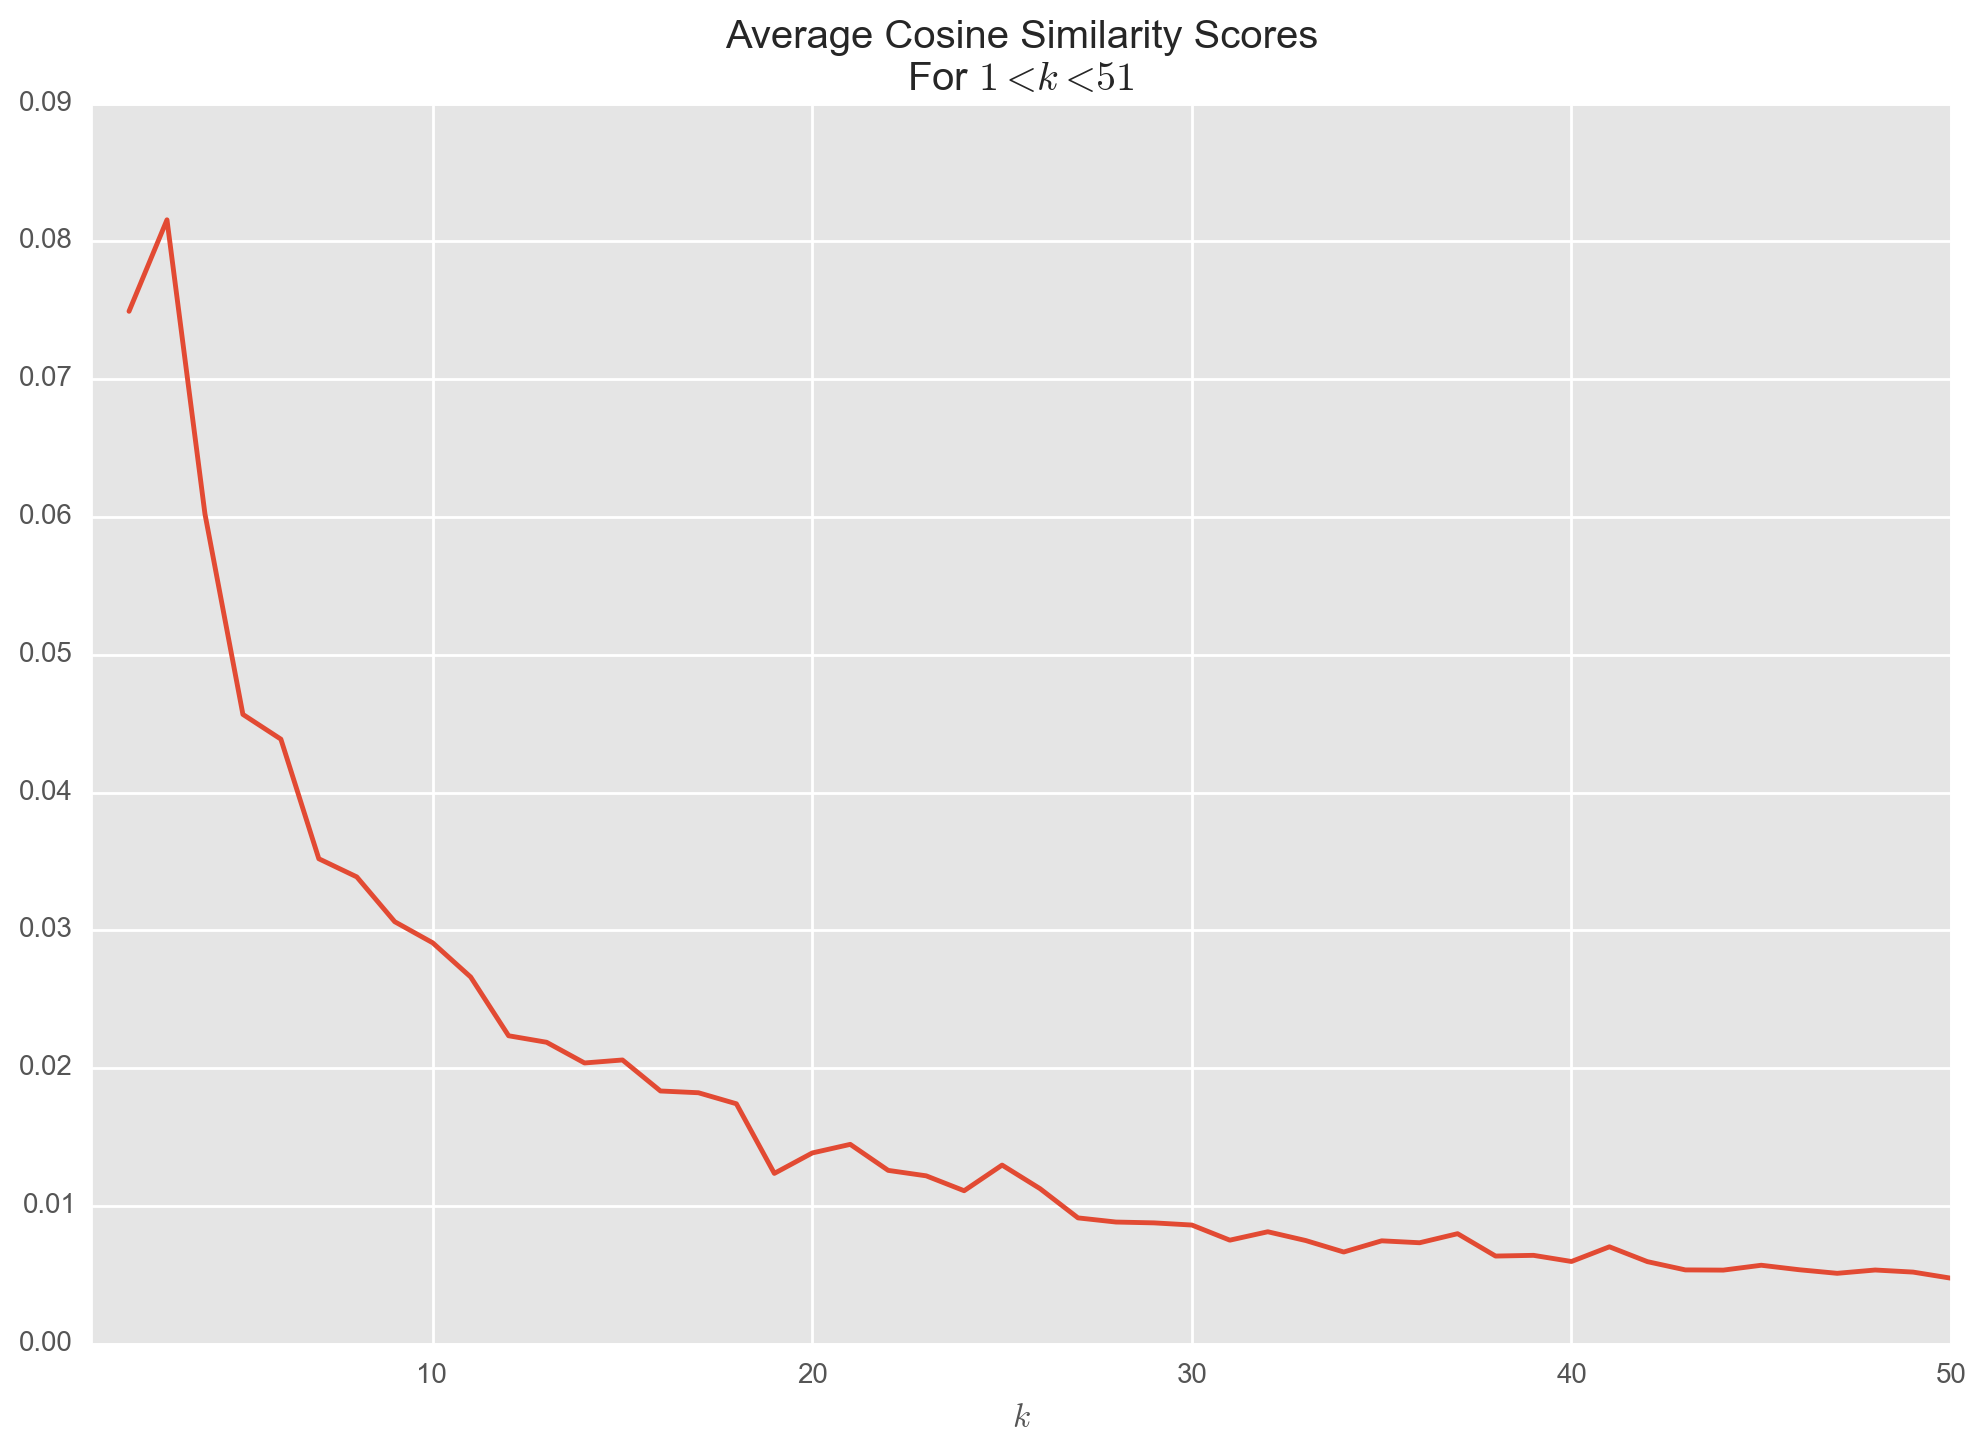

In [12]:
plt.figure(figsize=(12, 8))

plt.plot(range(2, K+1), ed)
# plt.plot(range(2, K+1), v)

plt.xlim(1);
plt.ylim(0);

plt.title('Average Cosine Similarity Scores\nFor $1 < k < %s$' % (K+1))
plt.xlabel('$k$')

In [13]:
n_topics = 26
n_top_words = 25

In [14]:
tfidf_feature_names = tfidf.get_feature_names()

In [15]:
nmf = NMF(n_components=n_topics, random_state=1).fit(data)

In [16]:
print_top_words(nmf, tfidf_feature_names, n_top_words)

Topic #0:
like stuff lot kind really different especially comedies things books funny feel people lots yes make variety tend ones bands type dont think probably types

Topic #1:
black david john life radiohead man bob tom books beatles sunshine dead mind american brothers hot james little keys white eternal city dylan michael young

Topic #2:
book movie best fav great saw day called can't seen finished life loved pizza it's .... story reader night watched pick time little person chicken

Topic #3:
favorite time include foods band probably authors author say bands shows artists far books genre pick hard recent listen current kind genres favorites artist right

Topic #4:
... .... know yes books say ..... lol ask hard goes right that's lots little come course start let's maybe bit later can't guess thing

Topic #5:
love eat cook live types especially .... going actually dance great cooking sushi life eating concerts true spicy healthy scary restaurants story absolutely foodie loved

Topic

In [17]:
W = nmf.components_
H = nmf.fit_transform(data)

In [18]:
W.shape

(26, 982)

In [19]:
H.shape

(50827, 26)

In [20]:
labels = np.argmax(H, axis=1)

In [21]:
print('Distribution of Samples by Cluster (Topic)')
pd.DataFrame(labels)[0].value_counts().sort_index()

Distribution of Samples by Cluster (Topic)


0     6138
1     8348
2     1734
3     3322
4     3481
5     2011
6     1481
7     1340
8     1772
9     2016
10    1391
11    1279
12    1324
13    1268
14    1424
15    1164
16    1582
17    1158
18    1436
19     766
20    1517
21     963
22     669
23     961
24     942
25    1340
dtype: int64

In [22]:
df_token_threshold['labels'] = labels

In [23]:
print('Average Token Count by Cluster (Topic)')
df_token_threshold.groupby('labels')['token_count'].mean()

Average Token Count by Cluster (Topic)


labels
0     283.262463
1     522.416747
2     389.129181
3     393.151114
4     434.696352
5     368.057683
6     412.584740
7     435.967910
8     489.607788
9     392.781250
10    433.149533
11    436.890539
12    528.741692
13    412.768139
14    393.141854
15    534.748282
16    407.047408
17    405.828152
18    394.768802
19    327.605744
20    352.145682
21    408.931464
22    359.188341
23    363.365245
24    341.927813
25    365.916418
Name: token_count, dtype: float64

In [24]:
for c in np.sort(df_token_threshold['labels'].unique()):
    if c == 0:
        tdf = df_token_threshold[df_token_threshold['labels'] == c]
        tdf_p = pd.DataFrame({str(c) :
                              tdf.ethnicity_.value_counts().sort_index()/\
                              tdf.ethnicity_.value_counts().sort_index().sum()}).reset_index()
    else:
        tdf = df_token_threshold[df_token_threshold['labels'] == c]
        tdf_p = pd.merge(tdf_p,
                         pd.DataFrame({str(c) :
                                       tdf.ethnicity_.value_counts().sort_index()/\
                                       tdf.ethnicity_.value_counts().sort_index().sum()}).reset_index(),
                         how='outer',
                         on='index')

tdf_p.fillna(0)
tdf_p.rename(columns={'index':'ethnicity_'}, inplace=True)

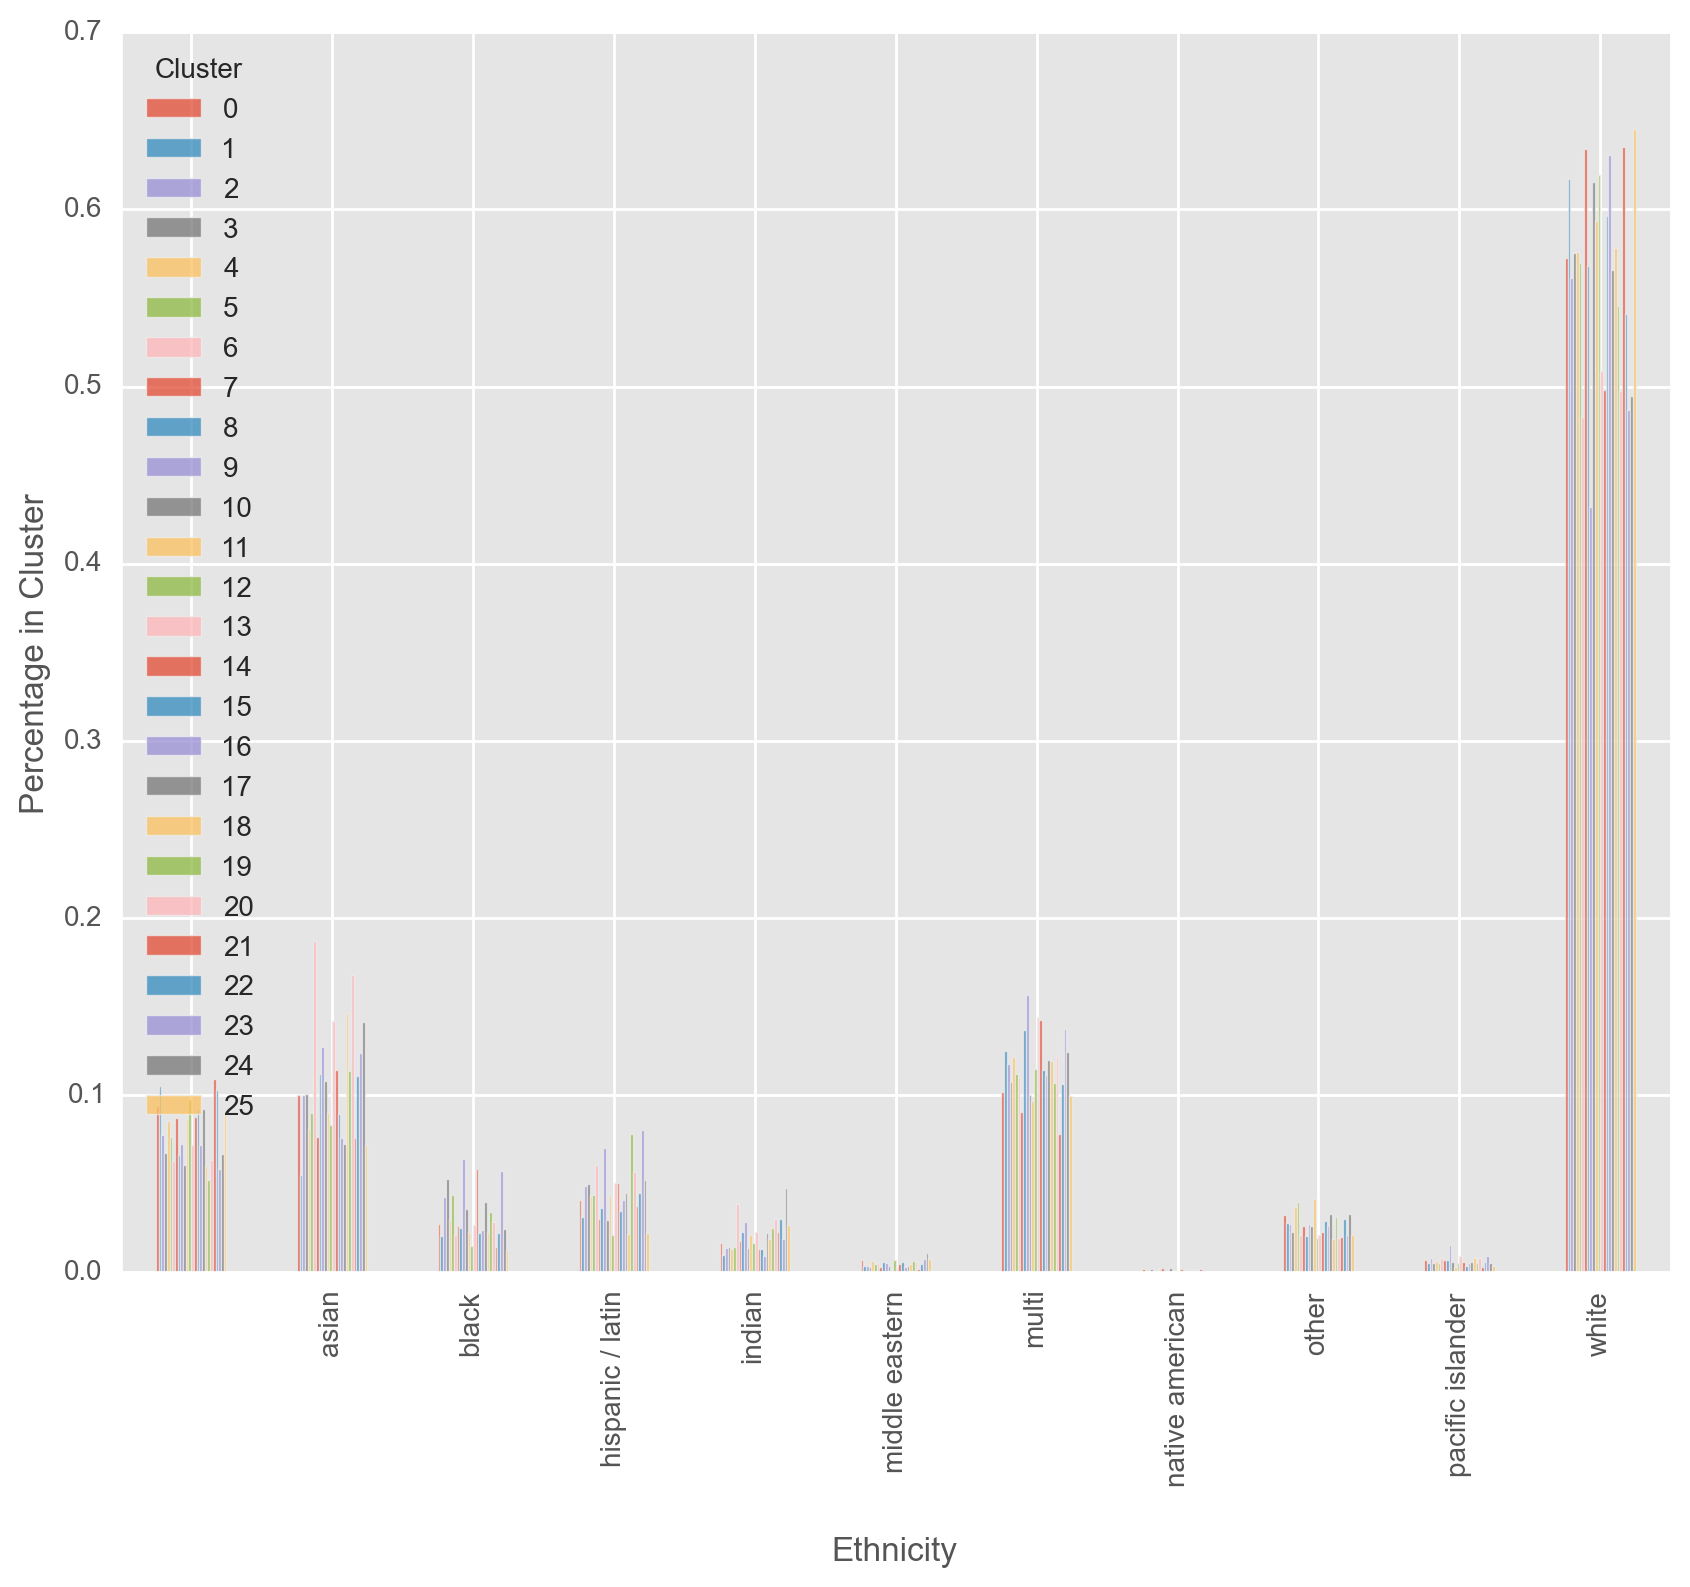

In [25]:
tdf_p.plot(alpha=0.75, figsize=(10, 8), kind='bar')

plt.xlim(-0.5, len(df_token_threshold.ethnicity_.unique())-0.5)
plt.xticks(tdf_p.index, tdf_p.ethnicity_, rotation=90);

plt.xlabel('\nEthnicity')
plt.ylabel('Percentage in Cluster')

plt.legend(range(n_topics), loc='upper left', title='Cluster')